In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
# from ekarus.e2e.devices.alpao_deformable_mirror import ALPAODM

from ekarus.e2e.utils.image_utils import reshape_on_mask, get_circular_mask

from numpy.ma import masked_array
from ekarus.analytical.zernike_generator import ZernikeGenerator

from arte.math.toccd import toccd


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize], cmap='twilight')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxLogValue=None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxLogValue is None:
        maxLogValue = xp.max(imageZoomedLog)
    imageZoomedLog -= maxLogValue
    imageShow(xp.asnumpy(imageZoomedLog), pixelSize=pixelSize, **kwargs)

In [3]:
def create_field_from_zernike_coefficients(mask, noll_ids, amplitudes):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return (1-mask) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids, amplitudes):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    mask_size = max(mask.shape)
    zg = ZernikeGenerator(xp.asnumpy(mask),mask_size//2)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(int(noll)))
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(int(noll)))

    return zern

In [4]:
ssao = SingleStageAO(tn='single_stage_8m')
ssao.initialize_turbulence()
# ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
# KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
# Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=0.002)

Initializing devices ...
Fried parameter is: 10.0 [cm]


In [5]:
def lyot_coronograph(focal_field, occulter_radius, lyot_stop, oversampling):

    focal_mask = get_circular_mask(focal_field.shape,mask_radius=occulter_radius*oversampling)
    lyot_stop = 1-get_circular_mask(focal_field.shape,mask_radius=lyot_stop*max(focal_field.shape))

    field_after_stop = focal_field * focal_mask
    pupil = xp.fft.ifft2(xp.fft.ifftshift(field_after_stop))
    lyot_pupil = pupil * lyot_stop
    coro_focal_field = xp.fft.fftshift(xp.fft.fft2(lyot_pupil))
    psf = xp.abs(coro_focal_field)**2

    return psf

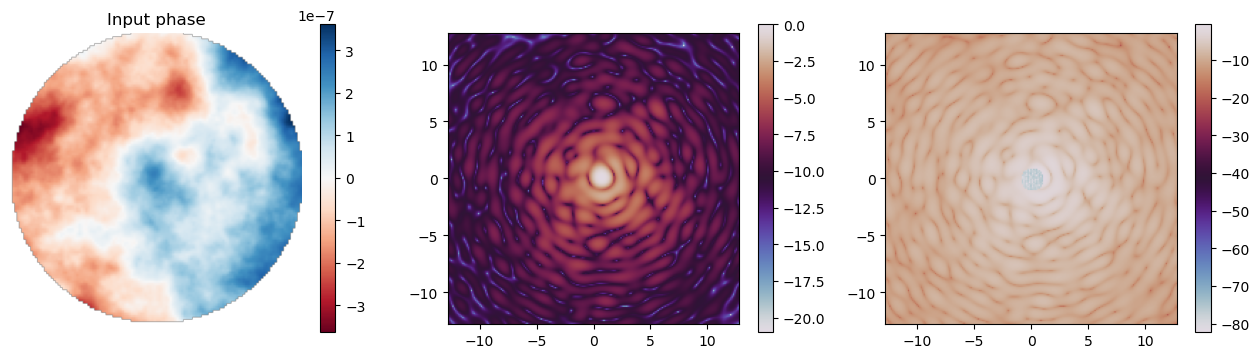

In [6]:
atmo_phase = ssao.get_phasescreen_at_time(0.2)/10
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

res_phase = atmo_phase[~ssao.cmask]
lambdaRef = ssao.pyr.lambdaInM
m2rad = 2*xp.pi/lambdaRef

oversampling = 8
field = (1-ssao.cmask) * xp.exp(1j*atmo_phase*m2rad)
padded_field = xp.pad(field, int((oversampling-1)/2*ssao.pupilSizeInPixels), mode='constant', constant_values=0.0)
fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
psf = xp.abs(fp_field)**2

coro_psf = lyot_coronograph(fp_field, occulter_radius=1, lyot_stop=0.96, oversampling=oversampling)
max_log_psf = xp.max(xp.log(psf))

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Input phase')
plt.axis('off')
plt.subplot(1,3,2)
showZoomCenter(psf,1/oversampling,maxLogValue=max_log_psf)
plt.subplot(1,3,3)
showZoomCenter(coro_psf,1/oversampling,maxLogValue=max_log_psf)


In [11]:
def get_coro_psf(phase, mask, lambdaInM, oversampling:int=12):
    m2rad = 2*xp.pi/lambdaInM
    pad_len = int((oversampling-1)/2*max(mask.shape))
    field_amp = 1-mask

    phase_2d = reshape_on_mask(phase, mask)
    in_field = field_amp * xp.exp(1j*phase_2d*m2rad)
    pad_field = xp.pad(in_field, pad_len, mode='constant', constant_values=0.0)
    focal_field = xp.fft.fftshift(xp.fft.fft2(pad_field))
    psf = xp.real(focal_field *xp.conj(focal_field))

    # pup_mask = field_amp > 0
    # avg_electric_field = xp.sum(in_field * pup_mask) / xp.sum(pup_mask)
    # coro_field = in_field - avg_electric_field * pup_mask
    # phase_var = reshape_on_mask(((phase-xp.mean(phase))*m2rad)**2, mask)
    # coro_field = field_amp * (xp.sqrt(xp.exp(-phase_var))-xp.exp(1j*phase_2d))
    # pad_coro_field = xp.pad(coro_field, pad_len, mode='constant', constant_values=0.0)
    # coro_focal_field = xp.fft.fftshift(xp.fft.fft2(pad_coro_field))
    # coro_psf = xp.real(coro_focal_field *xp.conj(coro_focal_field))
    coro_psf = lyot_coronograph(focal_field, occulter_radius=1, lyot_stop=0.96, oversampling=oversampling)

    # coro_psf /= xp.max(psf)
    # psf /= xp.max(psf)

    return coro_psf, psf

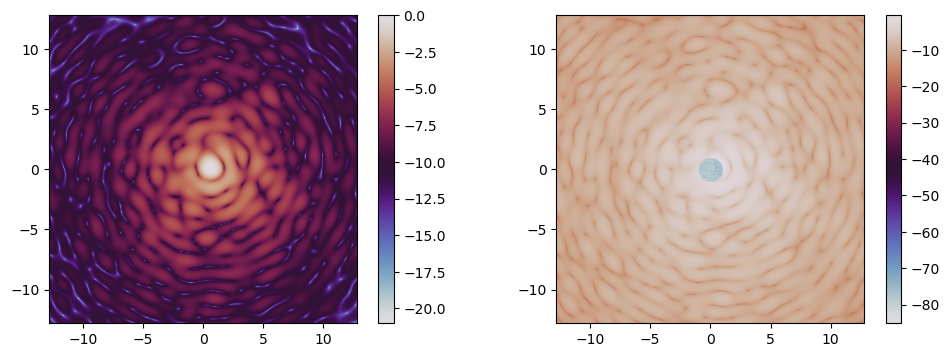

In [12]:
oversampling = 12
coro_psf, psf = get_coro_psf(atmo_phase[~ssao.cmask], ssao.cmask.copy(), lambdaRef, oversampling=oversampling)
max_log_psf = xp.max(xp.log(psf))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
showZoomCenter(psf,1/oversampling,maxLogValue=max_log_psf)
plt.subplot(1,2,2)
showZoomCenter(coro_psf,1/oversampling,maxLogValue=max_log_psf)

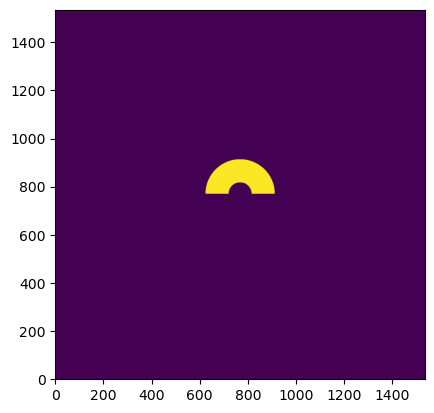

In [13]:
# Define dark hole region
iwa = 4
owa = 12

top = xp.ones(psf.shape, dtype=bool)
top[:psf.shape[0]/2+1,:] = 0

in_mask = get_circular_mask(psf.shape, mask_radius=iwa*oversampling)
out_mask = get_circular_mask(psf.shape, mask_radius=owa*oversampling)
dcd = xp.logical_or(~in_mask,out_mask)
dcd = ~dcd
dcd *= top


plt.figure()
plt.imshow(xp.asnumpy(dcd),origin='lower')

In [14]:
dm = ssao.dm
amp = 1e-10
IM = xp.zeros([int(xp.sum(dcd)),dm.Nacts])
mask = ssao.cmask.copy()

for i in range(dm.Nacts):
    cmd = xp.zeros(dm.Nacts)
    cmd[i] = amp
    phase = dm.IFF @ cmd
    coro_psf, _ = get_coro_psf(phase, mask, lambdaRef, oversampling=oversampling)
    push_dh = coro_psf[dcd]
    cmd[i] = -amp
    phase = dm.IFF @ cmd
    coro_psf, _ = get_coro_psf(phase, mask, lambdaRef, oversampling=oversampling)
    pull_dh = coro_psf[dcd]

    IM[:,i] = (push_dh-pull_dh)/2/amp

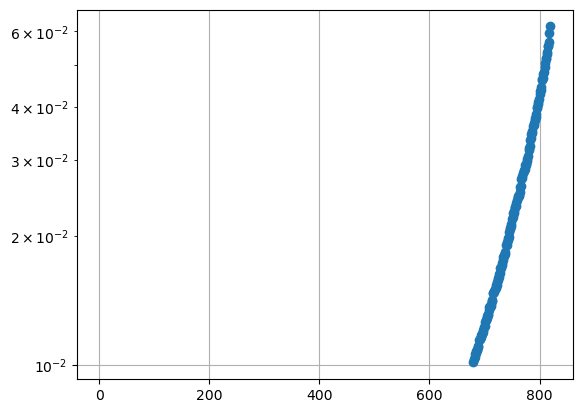

In [16]:
U,D,V = xp.linalg.svd(IM,full_matrices=False)
Dinv = 1/D
# Dinv[Dinv>1e-6] = 0
Dinv[Dinv<1e-2] = 0
Rec = (V.T * Dinv) @ U.T

plt.figure()
plt.plot(xp.asnumpy(Dinv),'o')
plt.yscale('log')
plt.grid()

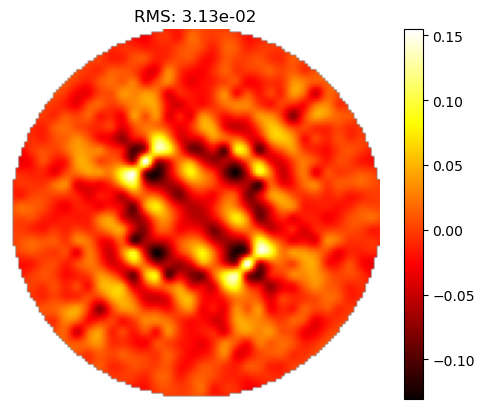

In [17]:
plt.figure()
plt.plot(xp.asnumpy(dm.plot_surface(dm.IFF @ V[-1,:])))

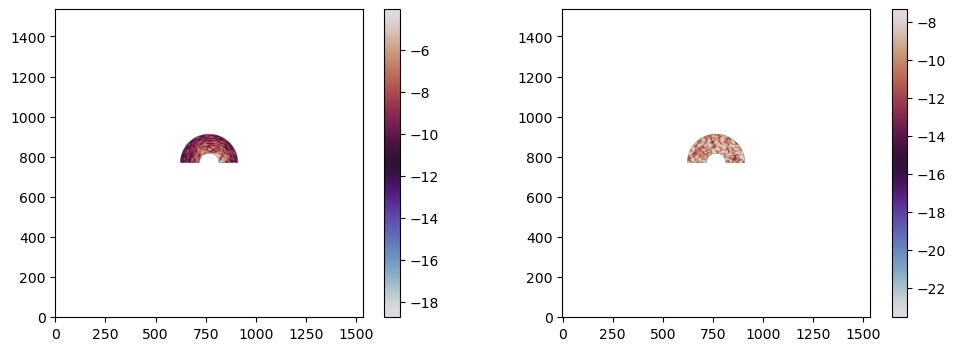

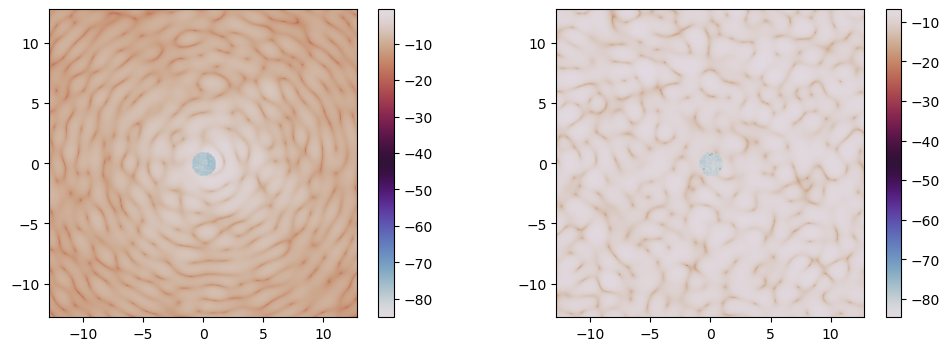

In [18]:
coro_psf, psf = get_coro_psf(res_phase, mask, lambdaRef, oversampling=oversampling)
dh = coro_psf[dcd]
maxLogPSF = xp.max(xp.log(psf))

dm_cmd = Rec @ dh
dm_phase = dm.IFF @ dm_cmd

new_coro_psf, _ = get_coro_psf(res_phase - dm_phase, mask, lambdaRef, oversampling=oversampling)
new_dh = new_coro_psf[dcd]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(xp.log(coro_psf)-maxLogPSF),mask=xp.asnumpy(1-dcd)),origin='lower',cmap='twilight')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(masked_array(xp.asnumpy(xp.log(new_coro_psf)-maxLogPSF),mask=xp.asnumpy(1-dcd)),origin='lower',cmap='twilight')
plt.colorbar()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
showZoomCenter(coro_psf,1/oversampling,maxLogValue=max_log_psf)
plt.subplot(1,2,2)
showZoomCenter(new_coro_psf,1/oversampling,maxLogValue=max_log_psf)

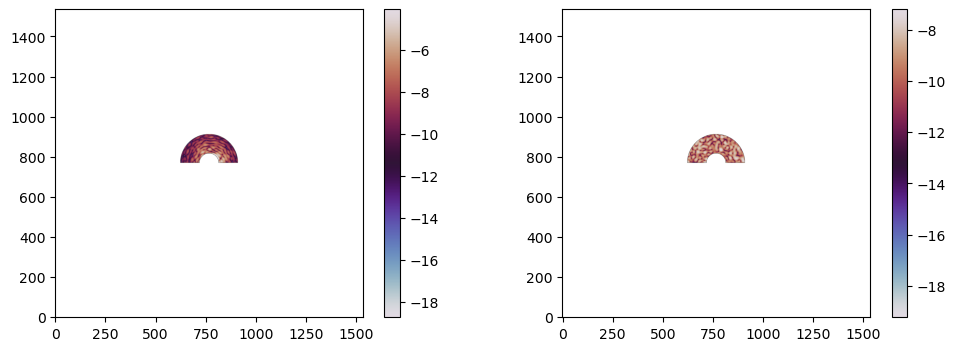

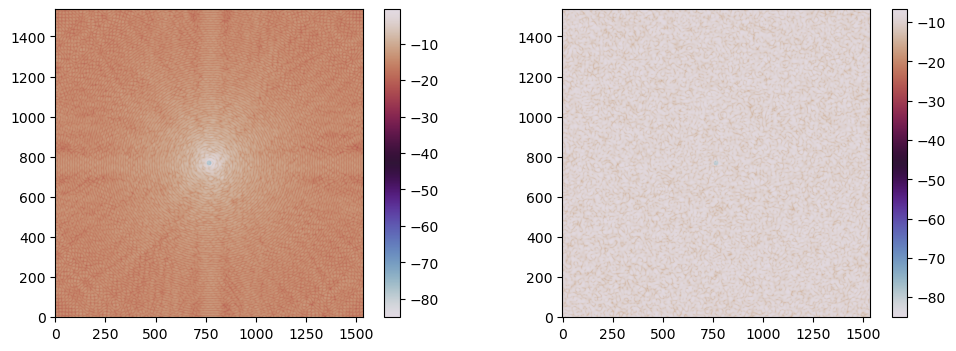

In [ ]:
coro_psf, psf = get_coro_psf(res_phase, mask, lambdaRef, oversampling=oversampling)
dh = coro_psf[dcd]
maxLogPSF = xp.max(xp.log(psf))

new_phase = res_phase.copy()
dm_cmd = xp.zeros(dm.Nacts)
Nits = 100
gain = 0.1

for i in range(Nits):
    new_coro_psf, _ = get_coro_psf(new_phase, mask, lambdaRef, oversampling=oversampling)
    dh = new_coro_psf[dcd]
    cmd = Rec @ dh
    dm_cmd = gain*cmd
    dm_phase = dm.IFF @ dm_cmd
    new_phase -= dm_phase


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(xp.log(coro_psf)-maxLogPSF),mask=xp.asnumpy(1-dcd)),origin='lower',cmap='twilight')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(masked_array(xp.asnumpy(xp.log(new_coro_psf)-maxLogPSF),mask=xp.asnumpy(1-dcd)),origin='lower',cmap='twilight')
plt.colorbar()